This script loads all of the hourly data for the most recent year.  It then saves the created data structure as a pickle (a compressed binary file) for faster loading in the future.

# Hourly Data #

In [1]:
# imports
import pandas as pd
import numpy as np
import time
from timeit import default_timer as timer

In [2]:
# define data location
#location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
location = '/Users/loki/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'

## Data Cleaning & Checking 

In [3]:
# # hourly data

# use_oct_in = pd.read_excel(location+'PECO Zip HourlyUsage_2017.10.xlsx')
# use_nov_in = pd.read_excel(location+'PECO Zip HourlyUsage_2017.11.xlsx') 
# use_dec_in = pd.read_excel(location+'PECO Zip HourlyUsage_2017.12.xlsx') 
# use_jan_in = pd.read_excel(location+'Zip_HourlylUsage_2018.01.xlsx')
# use_feb_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.02.xlsx')
# use_mar_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.03.xlsx')
# use_apr_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.04.xlsx')
# use_may_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.05.xlsx')
# use_jun_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.06.xlsx')
# use_jul_in = pd.read_excel(location+'Zip_HourlylUsage_2018.07.xlsx')
# use_aug_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.08.xlsx')
# use_sep_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.09.xlsx')

# end = timer()
# print((end - start)/60) # Time in minutes (~15 min)

In [4]:
# # merge use data
# hourly_in = [use_oct_in, use_nov_in, use_dec_in, use_jan_in, use_feb_in, use_mar_in, 
#              use_apr_in, use_may_in, use_jun_in, use_jul_in, use_aug_in, use_sep_in]
             
# use = pd.concat(hourly_in)

In [5]:
# # drop unused tables for memory space
# del (use_oct_in, use_nov_in, use_dec_in, use_jan_in, use_feb_in, use_mar_in, 
#      use_apr_in, use_may_in, use_jun_in, use_jul_in, use_aug_in, use_sep_in)
# del hourly_in

In [6]:
# # save as pickle so we don't have to do this again
# use.to_pickle(location+'hourly_use_raw.pkl.zip')
# del use

In [7]:
# load pickle
start = timer()

use = pd.read_pickle(location+'hourly_use_raw.pkl.zip')

end = timer()
print((end - start)/60) # Time in minutes (~.2 min - MUCH FASTER!!)

0.20651121616666615


In [8]:
# create ID tuple
ids = pd.Series(list(map(tuple, use[['DACCOUNTID', 'DMETERNO']].values)))
use['ID'] = ids.values

# find gas records
use = use.loc[use['UOM'] == 'CCF']
use = use.drop(columns=['UOM'])

# convert to datetime
use['Dt'] =  pd.to_datetime(use['METERREADDATE'])

In [9]:
# load customer data
customer_in = pd.read_excel(location+'PECO Zip Customer 2018.10.01 v2.xlsx', sheet_name="Account")
ids = pd.Series(list(map(tuple, customer_in[['DACCOUNTID', 'DMETERNO']].values)))
customer_in['ID'] = ids.values
customer = customer_in.drop(columns=['CITY', 'STATE', 'ZIPCODE', 'COUNTYCODE'])
del customer_in

## Data Restructuring ##

In [10]:
# functions for naming consistency
def decrement(x, startswith, split):
    """
    decrements a passed string of form "demo#" by 1
    
    Parameters
    ----------
    x : string to be decremented
    split : string to split on

    Returns
    ----------
    y : decremented string
    """
    if x.startswith(startswith):
        a,b = x.split(split)
        b = int(b)-1
        y = a + split + str(b)

        return y

    else:
        return x

    
def interval_to_hour(df):
    """
    function for fast rename/relabel during tidying process
    
    Parameters
    ----------
    df : pandas data frame

    Returns
    ----------
    df : data frame with updated column names
    """
    
    df = df.rename(columns=lambda x: decrement(x, "INTERVAL_", "_"))
    df = df.rename(columns=lambda x: x.replace("INTERVAL_", "HR"))
    return df

In [11]:
# rename for consistency
use = interval_to_hour(use)
use = use.drop(columns=['METERREADDATE','HR24'])

In [12]:
# Tidy / Stack data (transform into tall data - one row per customer per hour):
# ref: http://www.jeannicholashould.com/tidy-data-in-python.html
tidy_use = pd.melt(use, 
                   id_vars=['ID','DACCOUNTID','DMETERNO','Dt'],
                   var_name='Hour', value_name='Use')

In [13]:
# drop use from memory
del use

In [14]:
# relabel/retype
tidy_use['Hour'] = tidy_use['Hour'].str.extract('(\d+)').astype(int)

In [15]:
# append rate code data
tidy_use = tidy_use.merge(customer, how='inner', on=['ID','DACCOUNTID','DMETERNO'])
#tidy_use.head()

In [16]:
# create single column for date and time
tidy_use['year'] = pd.to_datetime(tidy_use['Dt'].values).year
tidy_use['month'] = pd.to_datetime(tidy_use['Dt'].values).month
tidy_use['day'] = pd.to_datetime(tidy_use['Dt'].values).day
tidy_use['datetime'] = pd.to_datetime(tidy_use[['year','month','day','Hour']])

In [17]:
# Add dummy variables for day-of-week
#use = use.join(pd.get_dummies(use['Dt'].dt.weekday_name))
tidy_use['Weekday'] = pd.get_dummies(tidy_use['Dt'].dt.weekday < 5)[True]

In [18]:
(tidy_use[['Weekday','REVENUCODE','Use']].groupby(['REVENUCODE','Weekday']).mean()
 .pivot_table(index='Weekday', columns='REVENUCODE', values='Use', fill_value=None))

REVENUCODE,1.0,3.0,5.0,12.0
Weekday,,,,
0,0.088452,0.728298,30.736621,0.051348
1,0.087278,0.755928,35.495842,0.051624


In [19]:
(tidy_use[['Hour','REVENUCODE','Use']].groupby(['REVENUCODE','Hour']).mean()
 .pivot_table(index='Hour', columns='REVENUCODE', values='Use', fill_value=None))

REVENUCODE,1.0,3.0,5.0,12.0
Hour,,,,
0,0.075189,0.563908,10.188124,0.048037
1,0.077569,0.569036,10.995016,0.049646
2,0.080540,0.585921,10.720258,0.052058
3,0.085904,0.605370,12.234807,0.054311
4,0.094154,0.662754,10.474880,0.056648
5,0.108184,0.762463,12.269754,0.059615
6,0.122373,0.866974,12.653584,0.065020
7,0.123240,0.921704,13.466625,0.067467
8,0.111360,0.932027,14.498820,0.062536


In [20]:
# Add dummy variables for hour-of-day
#tidy_use = tidy_use.join(pd.get_dummies(tidy_use['Hour'],prefix='HR'))

# Add dummy variables for part-of-day
tidy_use['MORN'] = pd.get_dummies((tidy_use['Hour'] >= 5) & (tidy_use['Hour'] < 9))[True] # 5-9 am
tidy_use['DAY'] = pd.get_dummies((tidy_use['Hour'] >= 9) & (tidy_use['Hour'] < 17))[True] # 9 am-5 pm
tidy_use['EVE'] = pd.get_dummies((tidy_use['Hour'] >= 17) & (tidy_use['Hour'] < 21))[True] # 5-10 pm
tidy_use['NIGHT'] = pd.get_dummies((tidy_use['Hour'] < 5) | (tidy_use['Hour'] >= 21) )[True] # 10 pm-6 am
# tidy_use.head()

In [21]:
(tidy_use[['REVENUCODE','MORN','DAY','EVE','NIGHT','Use']].groupby(['REVENUCODE','MORN','DAY','EVE','NIGHT']).mean()
 .pivot_table(index=['EVE','DAY','MORN','NIGHT'], columns='REVENUCODE', values='Use', fill_value=None))

REVENUCODE              1.0       3.0        5.0       12.0
EVE DAY MORN NIGHT                                         
0   0   0    1      0.082159  0.620576  26.445314  0.051700
        1    0      0.116289  0.870792  13.222196  0.063659
    1   0    0      0.078363  0.809700  45.703597  0.045903
1   0   0    0      0.088359  0.756594  47.417783  0.050404

In [22]:
# Add dummy variables for holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
#dr = pd.date_range(start=min(tidy_use['Dt']), end=max(tidy_use['Dt']))
dr = pd.date_range(start="1-1-2010", end="12-31-2020")
holidays = cal.holidays(start=dr.min(), end=dr.max())

tidy_use['Holiday'] = pd.get_dummies(tidy_use['Dt'].isin(holidays))[True]
del (USFederalHolidayCalendar, cal, dr, holidays)
#tidy_use.head()

In [23]:
# sort by date & time
tidy_use = tidy_use.drop(columns=['Dt','year','month','day','Hour'])
tidy_use = tidy_use.sort_values(by=['datetime'])
tidy_use = tidy_use.rename(columns={'datetime':'Dt'}) # for consistency
tidy_use.head()

,ID,DACCOUNTID,DMETERNO,Use,DCUSTOMERID,TARIFF,FUELTYPE,REVENUCODE,Dt,Weekday,MORN,DAY,EVE,NIGHT,Holiday
39207263,"(331345825806000, 3881647153052)",331345825806000,3881647153052,0.0,3387540197316,GH0,GAS,1.0,2017-10-01,0,0,0,0,1,0
15258191,"(131301502768284, 4464587014388)",131301502768284,4464587014388,0.0,16165253578784,GH0,GAS,1.0,2017-10-01,0,0,0,0,1,0
41605933,"(284922792955308, 729979045712)",284922792955308,729979045712,0.0,2921994604260,GH0,GAS,1.0,2017-10-01,0,0,0,0,1,0
41709601,"(152994924937308, 724945750304)",152994924937308,724945750304,0.0,3403523328224,UHC,GAS,3.0,2017-10-01,0,0,0,0,1,0
8166791,"(92034922962460, 609973195576)",92034922962460,609973195576,0.0,990318530984,GH0,GAS,1.0,2017-10-01,0,0,0,0,1,0


#### Quick look at amount of data we have per ID ####

In [24]:
# drop records with missing data
if len(tidy_use) == len(tidy_use.dropna(subset=['Use'])):
    print(f'There is no missing data in the {len(tidy_use)} rows of useage data')
else:
    tidy_use = tidy_use.dropna(subset=['Use'])

There is no missing data in the 54706704 rows of useage data


In [25]:
print(f"There are {len(tidy_use['DACCOUNTID'].drop_duplicates())} unique AccountIDs in the data")
print(f"There are {len(tidy_use['DMETERNO'].drop_duplicates())} unique MeterNos in the data")
ids = tidy_use['ID'].drop_duplicates()
print(f"There are {len(ids)} unique AccountID / MeterNo pairs in the data")

There are 6976 unique AccountIDs in the data
There are 6953 unique MeterNos in the data
There are 7097 unique AccountID / MeterNo pairs in the data


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
ids_to_plot = tidy_use.groupby(['ID']).count()
sns.distplot(ids_to_plot['Use'], bins=20, kde=False, rug=False)
plt.title('Frequency of IDs with X dates')

Text(0.5, 1.0, 'Frequency of IDs with X dates')

Text(0.5, 1.0, 'Frequency of IDs with at least 7920 hours (330 days)')

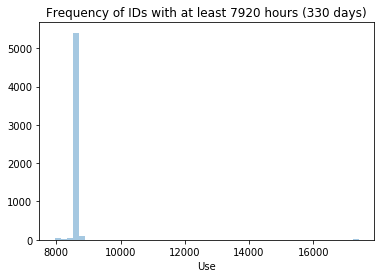

In [27]:
sns.distplot(ids_to_plot[ids_to_plot['Use'] > (7920)]['Use'], bins=50, kde=False, rug=False)
plt.title('Frequency of IDs with at least 7920 hours (330 days)')

#### Find IDs with sufficient data to build initial segments on --> reliable training set ####

In [28]:
# find IDs with at least 360 days of data
sufficient_ids = ids_to_plot[ids_to_plot['Use'] >= 8640].reset_index()['ID']
print(f"{100*len(sufficient_ids)/len(tidy_use['ID'].unique())} percent of IDs have at least 8640 hours (360 days) of data")

76.90573481752854 percent of IDs have at least 8640 hours (360 days) of data


In [29]:
# find the dates for which sufficient_ids all have data
pivoted = (tidy_use[tidy_use['ID'].isin(sufficient_ids)]
           .pivot_table(index=['Dt'], columns=['ID'], values='Use', fill_value=None))
sufficient_dates = pivoted.dropna().reset_index()['Dt']
del pivoted
print(f"The IDs with sufficient data overlap on {len(sufficient_dates)} hours ({len(sufficient_dates)/24} days) of the most recent year of data")

The IDs with sufficient data overlap on 7728 hours (322.0 days) of the most recent year of data


In [30]:
# filter total use dataset to contain only IDs who have sufficient data and only dates where sufficient_ids have data
sufficient_use = tidy_use[(tidy_use['ID'].isin(sufficient_ids)) & (tidy_use['Dt'].isin(sufficient_dates))]
#sufficient_use.head()

In [31]:
#sanity check
print(len(tidy_use))
print(len(sufficient_use))
print(len(ids))
print(len(sufficient_ids))

54706704
42418992
7097
5458


### Subgroup detection ###

In [32]:
# print(tidy_use[['ID','REVENUCODE']].drop_duplicates().groupby('REVENUCODE').count())
# print("nan           "+str(len(tidy_use[np.isnan(tidy_use['REVENUCODE'])][['ID']].drop_duplicates())))

In [33]:
# print(tidy_use[['ID','REVENUCODE']].drop_duplicates().groupby('REVENUCODE').count())
# print("nan           "+str(len(tidy_use[np.isnan(tidy_use['REVENUCODE'])][['ID']].drop_duplicates())))

In [34]:
# # recode 'REVENUCODE' as 'TYPE'
# def recode(df):
#     """combines REVENUCODE groups 1,12,nan to HOME and 3,5 to COMMERICAL"""
#     df['TYPE'] = None
#     df.loc[ df.REVENUCODE == 1, 'TYPE' ] = 'HOME'
#     df.loc[ df.REVENUCODE == 12, 'TYPE' ] = 'HOME'
#     df.loc[ np.isnan(df['REVENUCODE']), 'TYPE' ] = 'HOME'
#     df.loc[ df.REVENUCODE == 3, 'TYPE' ] = 'COMM'
#     df.loc[ df.REVENUCODE == 5, 'TYPE' ] = 'COMM'
    
#     #df['TYPE'][df['REVENUCODE']==1] = 'HOME'
#     #df['TYPE'][df['REVENUCODE']==12] = 'HOME'
#     #df['TYPE'][np.isnan(df['REVENUCODE'])] = 'HOME'
#     #df['TYPE'][df['REVENUCODE']==3] = 'COMM'
#     #df['TYPE'][df['REVENUCODE']==5] = 'COMM'
    
#     return df

In [35]:
# # ignore errors
# tidy_use = recode(tidy_use)
# sufficient_use = recode(sufficient_use)

### Save ###

In [ ]:
# save file(s) as pickles
# using save location to save with other data files outside of git repo
# data.to_csv(location+'peco.csv', sep='\t')
tidy_use.to_pickle(location+'peco_hourly.pkl.zip')
sufficient_use.to_pickle(location+'peco_sufficient_hourly.pkl.zip')
ids.to_pickle(location+'peco_hourly_ids.pkl.zip')
sufficient_ids.to_pickle(location+'peco_sufficient_hourly_ids.pkl.zip')

 ### Merge use & weather? ###

In [ ]:
# # load data
# hourly = pd.read_pickle(location+'peco_hourly.pkl.zip')
# sufficient_hourly = pd.read_pickle(location+'peco_sufficient_hourly.pkl.zip')
# weather = pd.read_pickle(location+'hourly_weather.pkl.zip')

In [ ]:
# # merge
# hourly = pd.merge(hourly, weather, how='inner', on=['Dt'])
# sufficient_hourly = pd.merge(sufficient_hourly, weather, how='inner', on=['Dt'])
# # CustIDs || Date | Consumption |||| Weather_variables 